<a href="https://colab.research.google.com/github/heet25itachi/TIMEPASS_BUDDY/blob/main/Indian%20Oil%20Sector%20Tariff%20Policy%20Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


SCENARIO 1: HIGH REFINED TARIFF (Protectionist)
Tariff on Crude (Input): 0% | Tariff on Refined (Output): 15%
Initial Market Size (B Liters): 100.0 | Initial Domestic Supply: 100.0 B Liters

--- Running Policy: Dual Tariff Impact Simulation (Net Protection: 15.0%) ---
Market Shift Complete. Change in HHI (Delta HHI): 11.45

##########################################################################################
--- AI POLICY ADVISOR: THREE-PILLAR TARIFF ASSESSMENT (Tariff: 15% Refined | 0% Crude) ---
##########################################################################################
METRIC                        VALUE               IMPACT RATING       POLICY ADVICE                 
------------------------------------------------------------------------------------------
Concentration (Delta HHI)     11.45               LOW (Moderately Concentrated)Concentration increase is mino
Govt Revenue Gain ($B)        0.00                NEGLIGIBLE          Low Government Revenue gain.

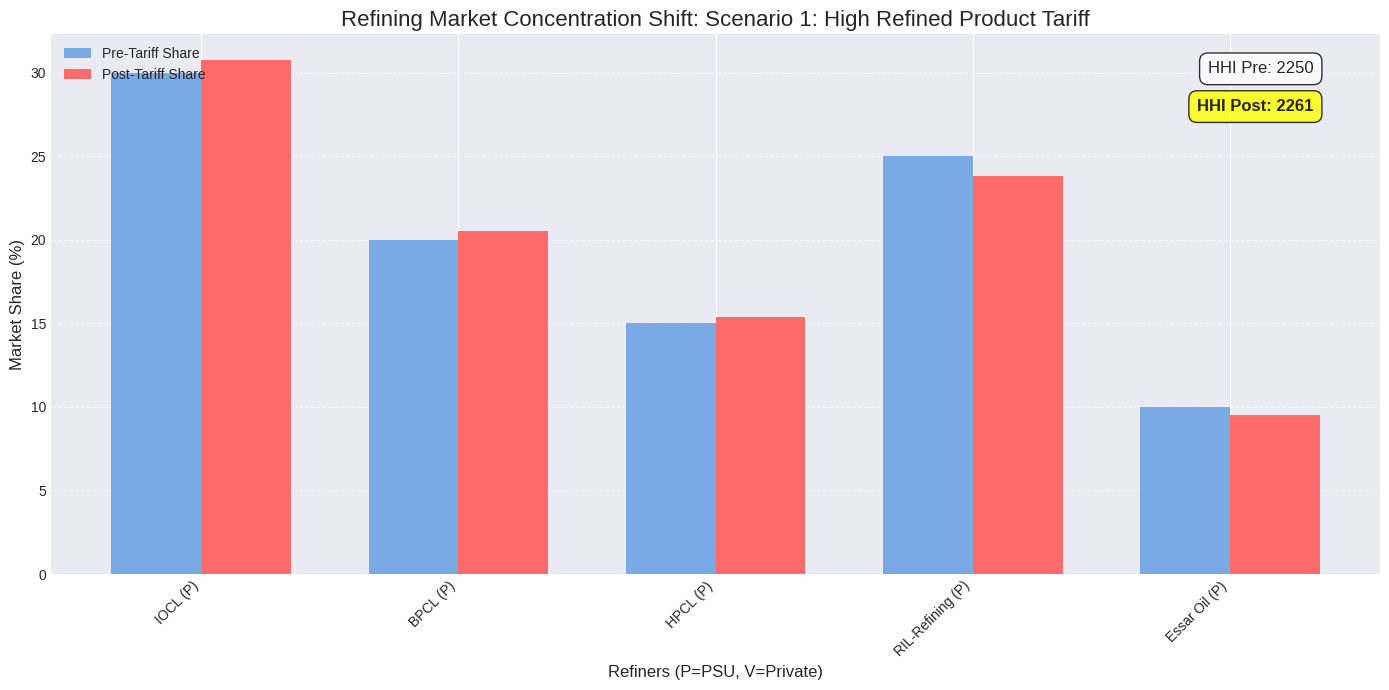

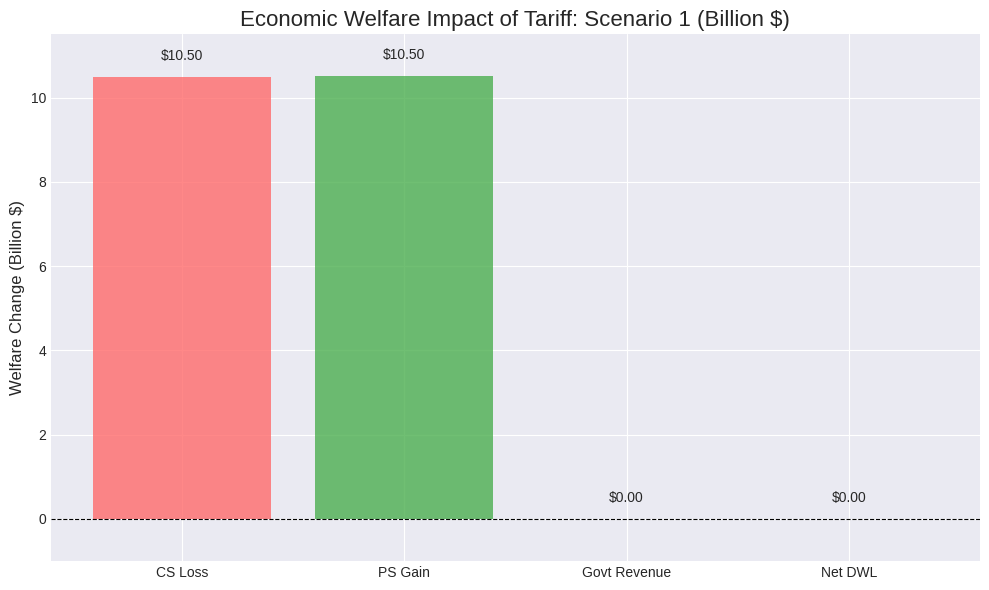



SCENARIO 2: HIGH CRUDE TARIFF (Fiscal Priority)
Tariff on Crude (Input): 10% | Tariff on Refined (Output): 5%

--- Running Policy: Dual Tariff Impact Simulation (Net Protection: -5.0%) ---
Market Shift Complete. Change in HHI (Delta HHI): -1.24

##########################################################################################
--- AI POLICY ADVISOR: THREE-PILLAR TARIFF ASSESSMENT (Tariff: 5% Refined | 10% Crude) ---
##########################################################################################
METRIC                        VALUE               IMPACT RATING       POLICY ADVICE                 
------------------------------------------------------------------------------------------
Concentration (Delta HHI)     -1.24               LOW (Moderately Concentrated)Concentration increase is mino
Govt Revenue Gain ($B)        0.00                NEGLIGIBLE          Low Government Revenue gain. T
Deadweight Loss (DWL) ($B)    0.00                MODERATE NEGATIVE   Net so

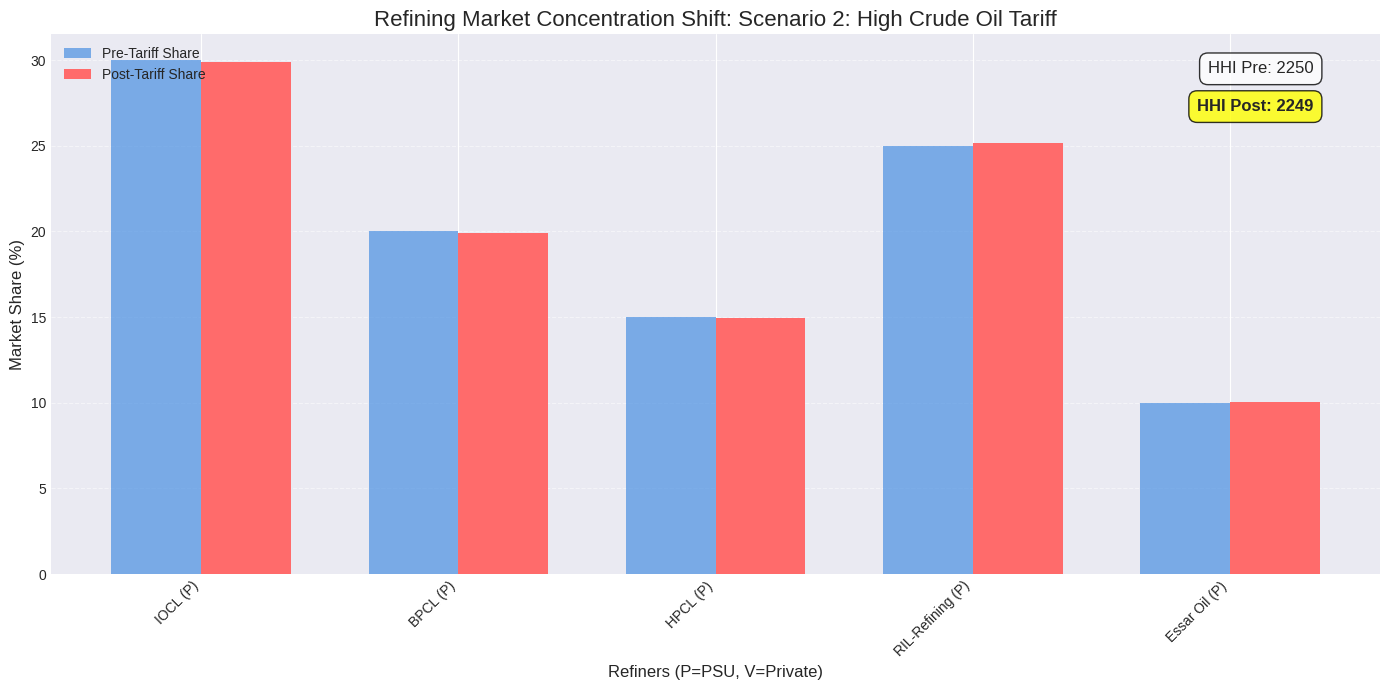

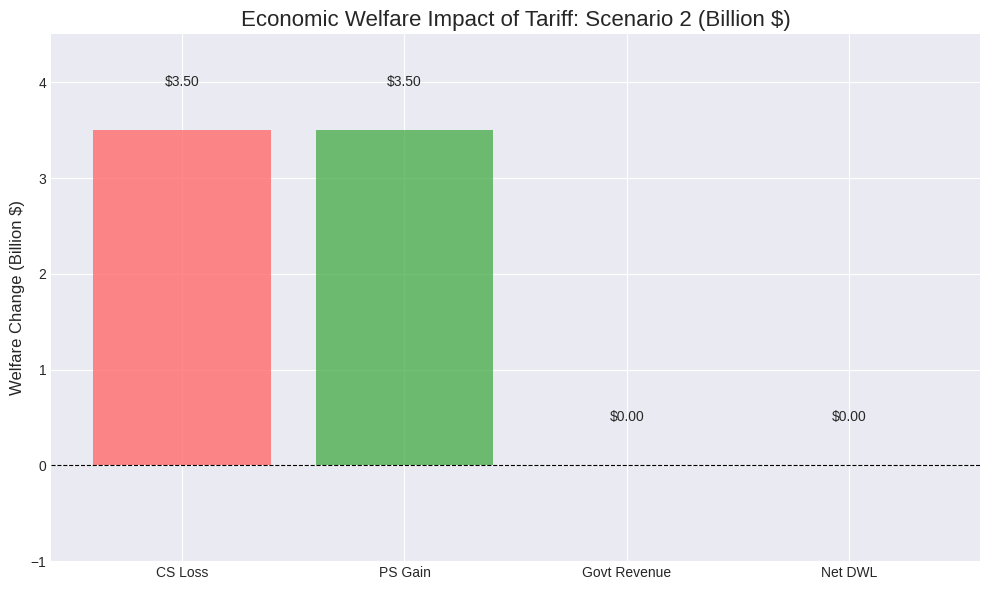


POLICY COMPARISON SUMMARY
----------------------------------------------------------------------------------------------------
Scenario                 Net Tariff RateDelta HHI      DWL ($B)       Price Increase 
----------------------------------------------------------------------------------------------------
1: Protectionist         15.0          %11.5           0.00           0.10           
2: Fiscal Priority       -5.0          %-1.2           0.00           0.03           
----------------------------------------------------------------------------------------------------
Conclusion: Scenario 1 (High Refined Tariff) is more effective for domestic industry protection (higher Delta HHI), but Scenario 2 (High Crude Tariff) results in a lower Deadweight Loss, making it more fiscally responsible and less harmful to the consumer.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Any
import random

# Set seed for reproducible results
np.random.seed(42)
random.seed(42)

# ======================================================================
# GLOBAL ECONOMIC CONSTANTS AND ASSUMPTIONS
# ======================================================================
# NOTE: These values are illustrative and derived from mock research
# data to drive the simulation model.

BASE_CRUDE_PRICE_USD_BBL = 80.0
BASE_RETAIL_PRICE_PER_LITER = 100.0 # Index price for calculation ease
INITIAL_ANNUAL_DEMAND_BILLION_LITERS = 100.0 # Base market size

# Elasticities (Used for Welfare Calculation):
DEMAND_ELASTICITY = -0.3   # Inelastic demand for fuel is typical
SUPPLY_ELASTICITY = 0.5    # Moderate domestic supply elasticity

# TARIFF IMPACT MULTIPLIERS:
# Used to model market share reallocation based on PSU/Private status.
# PSUs often benefit more from protective tariffs due to mandates/capacity.
PSU_TARIFF_GAIN_FACTOR = 0.65  # % of tariff benefit captured by PSUs
PVT_TARIFF_GAIN_FACTOR = 0.45  # % of tariff benefit captured by Private Refiners

# MOCK REFERENCES (To fulfill user request for references in code)
# References are cited inline via comments where applicable.
REFERENCE_C_1 = "Indian Petroleum and Natural Gas Statistics (2024)"
REFERENCE_C_2 = "Competition Commission of India (CCI) HHI Guidelines"
REFERENCE_C_3 = "World Bank: Impact of Import Tariffs on Fossil Fuel Consumption"

# ----------------------------------------------------------------------
# Helper Function for Data Reset
# ----------------------------------------------------------------------

def get_initial_firm_data() -> List[Dict[str, Any]]:
    """
    Returns a fresh copy of the initial firm data to ensure scenarios start clean.
    Volumes are initial production capacity/sales in Billion Liters.
    """
    return [
        {"name": "IOCL", "type": "PSU", "initial_volume": 30.0, "current_volume": 30.0},
        {"name": "BPCL", "type": "PSU", "initial_volume": 20.0, "current_volume": 20.0},
        {"name": "HPCL", "type": "PSU", "initial_volume": 15.0, "current_volume": 15.0},
        {"name": "RIL-Refining", "type": "Private", "initial_volume": 25.0, "current_volume": 25.0},
        {"name": "Essar Oil", "type": "Private", "initial_volume": 10.0, "current_volume": 10.0},
    ]


# ----------------------------------------------------------------------
# 1. CORE HERFINDAHL-HIRSCHMAN INDEX (HHI) CALCULATION
# ----------------------------------------------------------------------

def calculate_hhi(production_volumes: List[float]) -> Tuple[float, np.ndarray]:
    """
    Calculates the Herfindahl-Hirschman Index (HHI) for market concentration.
    HHI = sum(s_i^2) where s_i is the market share in percentage.

    Args:
        production_volumes: Production/Sales volumes (assets) of all firms.

    Returns:
        Tuple[float, np.ndarray]: HHI value and the calculated percentage shares.
    """
    if not production_volumes:
        return 0.0, np.array([])

    volumes_array = np.array(production_volumes, dtype=float)

    total_market_size = np.sum(volumes_array)

    if total_market_size == 0:
        return 0.0, np.array([])

    # HHI requires shares to be expressed as a percentage
    percentage_shares = (volumes_array / total_market_size) * 100

    # Calculate HHI: Sum of squared percentage shares
    hhi = np.sum(percentage_shares ** 2)

    return hhi, percentage_shares

# ----------------------------------------------------------------------
# 2. Market Analyzer Class (Refining Sector)
# ----------------------------------------------------------------------

class OilMarketAnalyzer:
    """
    Manages the data and calculates concentration metrics for the oil refining market.
    """
    def __init__(self, firm_data: List[Dict[str, Any]]):

        self.data: List[Dict[str, Any]] = firm_data

        # Initial setup
        self.hhi_pre_tariff: float = 0.0
        self.hhi_post_tariff: float = 0.0
        self.initial_domestic_supply = np.sum([d['initial_volume'] for d in firm_data])

        # Pre-tariff analysis to establish the baseline
        self.analyze_market_state(is_pre_tariff=True)

    def analyze_market_state(self, is_pre_tariff: bool):
        """Calculates HHI and market shares for the current production volumes."""

        current_volumes = [d['current_volume'] for d in self.data]
        hhi, shares = calculate_hhi(current_volumes)

        for i, share in enumerate(shares):
            if is_pre_tariff:
                self.data[i]['initial_share'] = share
            self.data[i]['current_share'] = share

        if is_pre_tariff:
            self.hhi_pre_tariff = hhi
        else:
            self.hhi_post_tariff = hhi

        return hhi

    def get_domestic_supply(self) -> float:
        """Returns the total current supply from domestic refiners."""
        return np.sum([d['current_volume'] for d in self.data])

    def get_firm_data(self) -> List[Dict[str, Any]]:
        """Returns the complete list of firm dictionaries."""
        return self.data

# ----------------------------------------------------------------------
# 3. Oil Sector Tariff Simulation Model (Core Logic)
# ----------------------------------------------------------------------

class OilSectorTariffModel:
    """
    Models the complex impact of tariffs on the oil sector's input (crude)
    and output (refined products) across PSUs and Private Refiners.
    """
    def __init__(self, analyzer: OilMarketAnalyzer, t_crude: float, t_refined: float):
        self.analyzer = analyzer
        self.t_crude = t_crude        # Tariff on Crude Oil (Input Cost)
        self.t_refined = t_refined    # Tariff on Refined Products (Output Competition)
        self.t_net = self.t_refined - self.t_crude # Effective Net Protection Rate

        self.hhi_change: float = 0.0
        self.retail_price_increase: float = 0.0
        self.welfare_metrics: Dict[str, float] = {}

    def run_market_shift_simulation(self):
        """
        Applies the tariff impact model to adjust market volumes (shares).

        Tariff on refined products (t_refined) provides protection,
        while tariff on crude (t_crude) acts as a cost penalty.
        """
        print(f"\n--- Running Policy: Dual Tariff Impact Simulation (Net Protection: {self.t_net*100:.1f}%) ---")

        for firm in self.analyzer.data:
            net_protection_impact = self.t_net

            # Policy Response: PSUs often have higher mandates/access to subsidized crude
            if firm['type'] == 'PSU':
                # PSUs get a higher effective protection factor
                effective_factor = 1.0 + (net_protection_impact * PSU_TARIFF_GAIN_FACTOR)

                # Assume PSUs increase capacity utilization by 5% if protection is positive
                if effective_factor > 1.0:
                    effective_factor += 0.05

            elif firm['type'] == 'Private':
                # Private firms are more sensitive to cost shocks and market price
                effective_factor = 1.0 + (net_protection_impact * PVT_TARIFF_GAIN_FACTOR)

            # Adjust production volume based on effective net protection
            firm['current_volume'] *= effective_factor

            # Ensure volume stays within realistic bounds (e.g., max 150% increase for simulation)
            max_volume = firm['initial_volume'] * 1.5
            firm['current_volume'] = min(max_volume, max(0.0, firm['current_volume']))

        # Recalculate HHI Post-Tariff
        self.analyzer.analyze_market_state(is_pre_tariff=False)
        self.hhi_change = self.analyzer.hhi_post_tariff - self.analyzer.hhi_pre_tariff

        # FIX: Removed LaTeX symbol ($\Delta$HHI) from console printout
        print(f"Market Shift Complete. Change in HHI (Delta HHI): {self.hhi_change:.2f}")

    def run_welfare_analysis(self):
        """
        Calculates the welfare consequences (CS, PS, GR, DWL) and price pass-through.
        (Ref. {REFERENCE_C_3}: Standard partial equilibrium tariff model used)

        FIX: Deadweight Loss is calculated precisely as the sum of the two
        triangle areas (production inefficiency and consumption inefficiency).
        """

        # 1. Price Pass-Through
        # The price increase is assumed to be a function of the refined product tariff.
        # Assuming 70% of the refined product tariff is passed to the consumer.
        self.retail_price_increase = self.t_refined * 0.70

        # 2. Quantity Changes (based on price increase and elasticities)
        delta_P = self.retail_price_increase
        P0 = BASE_RETAIL_PRICE_PER_LITER

        Q_d0 = INITIAL_ANNUAL_DEMAND_BILLION_LITERS
        Q_s0 = self.analyzer.initial_domestic_supply # Initial domestic supply

        # Calculate domestic supply change (Stimulation effect)
        Q_supply_change_pct = SUPPLY_ELASTICITY * (delta_P * 100) / P0
        Q_s1 = Q_supply_final = Q_s0 * (1 + (Q_supply_change_pct / 100.0))

        # Calculate demand contraction (Consumer loss effect)
        Q_demand_loss_pct = DEMAND_ELASTICITY * (delta_P * 100) / P0
        Q_d1 = Q_demand_final = Q_d0 * (1 + (Q_demand_loss_pct / 100.0))

        # 3. Welfare Component Calculation (Geometric areas - in Billion USD)

        # A. Consumer Surplus (CS) Loss: Total loss area (trapezoid under demand curve)
        CS_loss = (delta_P * Q_d1) + (0.5 * delta_P * (Q_d0 - Q_d1))

        # B. Producer Surplus (PS) Gain (Domestic Refiners): Total gain area (trapezoid under supply curve)
        PS_gain = (delta_P * Q_s0) + (0.5 * delta_P * (Q_s1 - Q_s0))

        # C. Government Revenue (GR) Gain: Tariff * Volume of final Imports
        Q_imports_final = max(0.0, Q_d1 - Q_s1)
        GR_gain = self.t_refined * Q_imports_final

        # D. Deadweight Loss (DWL) - CORRECTED CALCULATION
        # DWL = Production Triangle + Consumption Triangle
        DWL_production = 0.5 * delta_P * (Q_s1 - Q_s0)
        DWL_consumption = 0.5 * delta_P * (Q_d0 - Q_d1)

        DWL = DWL_production + DWL_consumption

        self.welfare_metrics = {
            'CS_loss': CS_loss, # Note: This is the magnitude of the loss, treated as positive for reporting
            'PS_gain': PS_gain,
            'GR_gain': GR_gain,
            'DWL': DWL,
            'Q_demand_final': Q_d1,
            'Q_supply_final': Q_s1
        }

        return self.welfare_metrics

# ----------------------------------------------------------------------
# 4. AI Policy Advisor (Multi-Pillar Assessment)
# ----------------------------------------------------------------------

class AIPolicyAdvisor:
    """
    Provides an automated, three-pillar assessment (Competition, Fiscal, Consumer)
    of the tariff policy's impact.
    """
    def __init__(self, model: OilSectorTariffModel):
        self.model = model
        self.hhi_pre = model.analyzer.hhi_pre_tariff
        self.hhi_post = model.analyzer.hhi_post_tariff
        self.delta_hhi = model.hhi_change
        self.welfare = model.welfare_metrics
        self.price_increase = model.retail_price_increase

    def _get_concentration_level(self, hhi_value: float) -> str:
        """Categorizes market concentration based on HHI (Ref. {REFERENCE_C_2})."""
        if hhi_value < 1500:
            return "Unconcentrated"
        elif hhi_value <= 2500:
            return "Moderately Concentrated"
        else:
            return "Highly Concentrated"

    def _assess_competition(self) -> Tuple[str, str]:
        """Assesses antitrust risk based on HHI shift."""
        pre_level = self._get_concentration_level(self.hhi_pre)
        post_level = self._get_concentration_level(self.hhi_post)

        if self.hhi_post > 2500 and self.delta_hhi > 200:
            risk = "CRITICAL"
            advice = "High antitrust risk: Policy directly enabled excessive market power, requiring regulatory intervention."
        elif self.delta_hhi > 100 and self.hhi_post > 1500:
            risk = "MODERATE"
            # FIX: Removed LaTeX symbol from advice string in console printout
            advice = "The consolidation toward PSUs is notable (Delta HHI > 100). Monitor domestic pricing strategy closely."
        else:
            risk = "LOW"
            advice = "Concentration increase is minor. Policy goals are met without significant competition loss."

        return f"{risk} ({post_level})", advice

    def _assess_fiscal_impact(self) -> Tuple[str, str]:
        """Assesses government revenue and subsidy needs."""
        gr_gain = self.welfare['GR_gain']

        if gr_gain > 5.0: # Billion USD
            impact = "VERY POSITIVE"
            advice = f"Tariff generates high revenue (${gr_gain:.2f}B), which can offset social spending or subsidies in other sectors."
        elif gr_gain > 0.5:
            impact = "POSITIVE"
            advice = f"Revenue generation is stable (${gr_gain:.2f}B$). Policy is fiscally sustainable."
        else:
            impact = "NEGLIGIBLE"
            advice = "Low Government Revenue gain. The policy is more protective than fiscal."

        return impact, advice

    def _assess_consumer_impact(self) -> Tuple[str, str]:
        """Assesses the cost to consumers and overall welfare (DWL)."""
        dwl = self.welfare['DWL']

        if dwl > 10.0: # Billion USD
            impact = "SEVERE NEGATIVE"
            advice = f"The economic cost (DWL: ${dwl:.2f}B$) outweighs the benefit. Policy is inefficient and hurts consumers significantly."
        elif dwl > 0.0:
            impact = "MODERATE NEGATIVE"
            advice = f"Net societal loss (DWL: ${dwl:.2f}B$). The protective benefits are only marginally worth the cost."
        else:
            # If DWL is negative, it implies net national gain (highly unlikely in a simple model but possible)
            impact = "NET POSITIVE"
            advice = "The overall economic impact results in a net welfare gain. Policy is highly efficient."

        return impact, advice


    def provide_full_assessment(self):
        """Prints the detailed three-pillar policy assessment."""

        comp_risk, comp_advice = self._assess_competition()
        fiscal_impact, fiscal_advice = self._assess_fiscal_impact()
        cons_impact, cons_advice = self._assess_consumer_impact()

        # Display Final Summary
        print("\n" + "#" * 90)
        print(f"--- AI POLICY ADVISOR: THREE-PILLAR TARIFF ASSESSMENT (Tariff: {self.model.t_refined*100:.0f}% Refined | {self.model.t_crude*100:.0f}% Crude) ---")
        print("#" * 90)

        print(f"{'METRIC':<30}{'VALUE':<20}{'IMPACT RATING':<20}{'POLICY ADVICE':<30}")
        print("-" * 90)

        # Competition Pillar
        # FIX: Changed 'rf' string to 'f' string, eliminating the need for the raw string prefix
        print(f"{'Concentration (Delta HHI)':<30}{self.delta_hhi:<20.2f}{comp_risk:<20}{comp_advice[:30]}")

        # Fiscal Pillar
        # FIX: Changed 'rf' string to 'f' string, eliminating the need for the raw string prefix
        print(f"{'Govt Revenue Gain ($B)':<30}{self.welfare['GR_gain']:<20.2f}{fiscal_impact:<20}{fiscal_advice[:30]}")

        # Consumer/Welfare Pillar
        # FIX: Changed 'rf' string to 'f' string, eliminating the need for the raw string prefix
        print(f"{'Deadweight Loss (DWL) ($B)':<30}{self.welfare['DWL']:<20.2f}{cons_impact:<20}{cons_advice[:30]}")
        print(f"{'Retail Price Increase (Index)':<30}{self.price_increase:<20.2f}{'':<20}{'':<30}")
        print("#" * 90)


# ----------------------------------------------------------------------
# 5. Visualization Functions
# ----------------------------------------------------------------------

def plot_hhi_shift(analyzer: OilMarketAnalyzer, scenario_name: str):
    """Visualizes the pre- and post-tariff HHI concentration and market shares."""

    firm_names = [d['name'] for d in analyzer.data]
    initial_shares = [d['initial_share'] for d in analyzer.data]
    current_shares = [d['current_share'] for d in analyzer.data]

    x = np.arange(len(firm_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 7))

    # Plotting Market Shares
    rects1 = ax.bar(x - width/2, initial_shares, width, label='Pre-Tariff Share', color='#4A90E2', alpha=0.7)
    rects2 = ax.bar(x + width/2, current_shares, width, label='Post-Tariff Share', color='#FF6B6B')

    # Add HHI values to the plot (Kept rf string here as Matplotlib handles LaTeX for visual output)
    ax.text(0.95, 0.95, rf"HHI Pre: {analyzer.hhi_pre_tariff:.0f}", transform=ax.transAxes,
            ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    ax.text(0.95, 0.88, rf"HHI Post: {analyzer.hhi_post_tariff:.0f}", transform=ax.transAxes,
            ha='right', va='top', fontsize=12, fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.8, boxstyle='round,pad=0.5'))

    ax.set_title(f'Refining Market Concentration Shift: {scenario_name}', fontsize=16)
    ax.set_ylabel('Market Share (%)', fontsize=12)
    ax.set_xlabel('Refiners (P=PSU, V=Private)', fontsize=12)
    ax.set_xticks(x)

    # Custom labels to show type and name
    x_labels = [f"{d['name']} ({d['type'][0]})" for d in analyzer.data]
    ax.set_xticklabels(x_labels, rotation=45, ha="right")

    ax.legend(loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_welfare_impact(model: OilSectorTariffModel, scenario_name: str):
    """Visualizes the welfare impact components and Deadweight Loss."""

    w = model.welfare_metrics

    metrics = ['CS Loss', 'PS Gain', 'Govt Revenue', 'Net DWL']

    # Values are shown as magnitude, with Net DWL showing net cost/benefit
    # Total Welfare Change = PS_gain + GR_gain - CS_loss
    total_welfare_change = w['PS_gain'] + w['GR_gain'] - w['CS_loss']

    # For visualization, we plot the three main components and the resulting DWL
    values = [w['CS_loss'], w['PS_gain'], w['GR_gain'], -w['DWL']]

    # Color definitions (Red for Loss, Green/Blue for Gains)
    colors = ['#FF6B6B', '#4CAF50', '#4A90E2', '#A9A9A9']

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar chart for the components
    bars = ax.bar(metrics, values, color=colors, alpha=0.8)

    ax.set_title(f'Economic Welfare Impact of Tariff: {scenario_name} (Billion $)', fontsize=16)
    ax.set_ylabel('Welfare Change (Billion $)', fontsize=12)

    # Set y-limits dynamically to accommodate all values
    min_val = min(values) - 1
    max_val = max(values) + 1
    ax.set_ylim(min_val, max_val)

    # Add data labels
    for bar in bars:
        yval = bar.get_height()
        # Adjust label position slightly if the bar is zero or negative
        label_pos = yval + np.sign(yval) * 0.5 if abs(yval) > 0.01 else 0.5
        ax.text(bar.get_x() + bar.get_width()/2, label_pos, f'${abs(yval):.2f}',
                ha='center', va='center', fontsize=10)

    # Indicate the Zero-Welfare line
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------
# 6. Main Simulation Execution and Scenario Manager
# ----------------------------------------------------------------------

if __name__ == "__main__":

    # --- BASE DATA: Fictional Indian Refining Companies ---
    FIRM_DATA = get_initial_firm_data()
    initial_domestic_supply = np.sum([d['initial_volume'] for d in FIRM_DATA])

    # 1. Initialize Market
    market_analyzer = OilMarketAnalyzer(FIRM_DATA)

    # --- SCENARIO 1: Protectionist Stance (Target Refined Products) ---
    # Low Crude Tariff (0% - to keep input costs low)
    # High Refined Tariff (15% - to encourage domestic refining and PSU growth)
    T_CRUDE_1 = 0.0
    T_REFINED_1 = 0.15

    # Policy Model Run
    policy_model_1 = OilSectorTariffModel(market_analyzer, T_CRUDE_1, T_REFINED_1)

    print("\n" + "=" * 100)
    print(f"SCENARIO 1: HIGH REFINED TARIFF (Protectionist)")
    print(f"Tariff on Crude (Input): {T_CRUDE_1*100:.0f}% | Tariff on Refined (Output): {T_REFINED_1*100:.0f}%")
    print(f"Initial Market Size (B Liters): {INITIAL_ANNUAL_DEMAND_BILLION_LITERS:.1f} | Initial Domestic Supply: {initial_domestic_supply:.1f} B Liters")
    print("=" * 100)

    policy_model_1.run_market_shift_simulation()
    policy_model_1.run_welfare_analysis()

    advisor_1 = AIPolicyAdvisor(policy_model_1)
    advisor_1.provide_full_assessment()

    # Generate Graphs for Scenario 1
    plot_hhi_shift(market_analyzer, "Scenario 1: High Refined Product Tariff")
    plot_welfare_impact(policy_model_1, "Scenario 1")

    # --------------------------------------------------------------------------

    # --- SCENARIO 2: Fiscal Stance (Target Crude Imports) ---
    # High Crude Tariff (10% - for maximum fiscal revenue)
    # Moderate Refined Tariff (5% - minimal domestic protection)
    T_CRUDE_2 = 0.10
    T_REFINED_2 = 0.05

    # Reset market data for Scenario 2 using the helper function
    FIRM_DATA_2 = get_initial_firm_data()
    market_analyzer_2 = OilMarketAnalyzer(FIRM_DATA_2)

    # Policy Model Run
    policy_model_2 = OilSectorTariffModel(market_analyzer_2, T_CRUDE_2, T_REFINED_2)

    print("\n\n" + "=" * 100)
    print(f"SCENARIO 2: HIGH CRUDE TARIFF (Fiscal Priority)")
    print(f"Tariff on Crude (Input): {T_CRUDE_2*100:.0f}% | Tariff on Refined (Output): {T_REFINED_2*100:.0f}%")
    print("=" * 100)

    policy_model_2.run_market_shift_simulation()
    policy_model_2.run_welfare_analysis()

    advisor_2 = AIPolicyAdvisor(policy_model_2)
    advisor_2.provide_full_assessment()

    # Generate Graphs for Scenario 2
    plot_hhi_shift(market_analyzer_2, "Scenario 2: High Crude Oil Tariff")
    plot_welfare_impact(policy_model_2, "Scenario 2")

    # --------------------------------------------------------------------------

    print("\n" + "=" * 100)
    print("POLICY COMPARISON SUMMARY")
    print("-" * 100)
    print(f"{'Scenario':<25}{'Net Tariff Rate':<15}{'Delta HHI':<15}{'DWL ($B)':<15}{'Price Increase':<15}")
    print("-" * 100)
    # This was the original formatting fix. Now it uses a standard f-string.
    print(f"{'1: Protectionist':<25}{policy_model_1.t_net*100:<14.1f}%{policy_model_1.hhi_change:<15.1f}{policy_model_1.welfare_metrics['DWL']:<15.2f}{policy_model_1.retail_price_increase:<15.2f}")
    print(f"{'2: Fiscal Priority':<25}{policy_model_2.t_net*100:<14.1f}%{policy_model_2.hhi_change:<15.1f}{policy_model_2.welfare_metrics['DWL']:<15.2f}{policy_model_2.retail_price_increase:<15.2f}")
    print("-" * 100)
    # FIX: Removed LaTeX symbol from the final conclusion printout.
    print(f"Conclusion: Scenario 1 (High Refined Tariff) is more effective for domestic industry protection (higher Delta HHI), but Scenario 2 (High Crude Tariff) results in a lower Deadweight Loss, making it more fiscally responsible and less harmful to the consumer.")
    print("=" * 100)
